In [2]:
import src.tmlsm.data_t2 as td2
import importlib
import os
import jax.numpy as jnp
import src.tmlsm.visualization as vis
importlib.reload(vis)
importlib.reload(td2)
import jax
import jax.random as jrandom
import src.tmlsm.models as tm
import src.tmlsm.losses as tl
importlib.reload(tm)
importlib.reload(tl)


<module 'src.tmlsm.losses' from 'c:\\Users\\alexp\\Desktop\\Tutorium Neu\\ML-Tutorial-WS25_26\\ffnn_introduction\\src\\tmlsm\\losses.py'>

In [3]:
# Global Variables

# Define the structural tensor
G_ti = jnp.array([[4.0, 0.0, 0.0],
                  [0.0, 0.5, 0.0],
                  [0.0, 0.0, 0.5]])

In [5]:
base_path = r"C:\Users\alexp\Desktop\Tutorium Neu\ML-Tutorial-WS25_26\hyperelasticity\data"
# Lukas C:\Users\fromm\OneDrive\Master\Tutorium Machine Learning
# Alex C:\Users\alexp\Desktop\Tutorium Neu
F_uni, P_uni, W_uni = td2.load_hyperelastic_data(os.path.join(base_path, r"calibration\uniaxial.txt"))
F_ps, P_ps, W_ps = td2.load_hyperelastic_data(os.path.join(base_path, r"calibration\pure_shear.txt"))
F_bi, P_bi, W_bi = td2.load_hyperelastic_data(os.path.join(base_path, r"calibration\biaxial.txt"))
F_bi_test, P_bi_test, W_bi_test = td2.load_hyperelastic_data(os.path.join(base_path, r"test\biax_test.txt"))

C = F_ps.transpose(0, 2, 1) @ F_ps # right Cauchy Green tensor

F_jax = jnp.array(F_bi)  # Convert to JAX array
invariants_computed = td2.compute_all_invariants(F_jax, G_ti)

# Load reference data
invariants_reference = td2.load_invariants(
    os.path.join(base_path, r"invariants\I_biaxial.txt")
)

W_reference = td2.compute_analytical_W(td2.load_invariants(r"C:\Users\alexp\Desktop\Tutorium Neu\ML-Tutorial-WS25_26\hyperelasticity\data\invariants\I_biaxial.txt"))
W_computed = td2.compute_analytical_W(invariants_computed)
print(jnp.max(jnp.abs(W_reference - W_computed)))

2.2888184e-05


### 1.2 Comparison Invariants loaded and Computed

In [6]:
# Test with biaxial data
F_jax = jnp.array(F_bi)  # Convert to JAX array
invariants_computed = td2.compute_all_invariants(F_jax, G_ti)

# Load reference data
invariants_reference = td2.load_invariants(
    os.path.join(base_path, r"invariants\I_biaxial.txt")
)

print("Computed invariants (first 5 rows):")
print(invariants_computed[:5])
print("\nReference invariants (first 5 rows):")
print(invariants_reference[:5])
print("\nMaximum error:")
print(jnp.max(jnp.abs(invariants_computed - invariants_reference)))

Computed invariants (first 5 rows):
[[3.1578465  0.41875207 2.4805038  3.0964804 ]
 [3.1446934  0.4289451  2.500906   3.1560528 ]
 [3.1314847  0.43914768 2.5216777  3.2147076 ]
 [3.118251   0.44935584 2.542835   3.272414  ]
 [3.1050224  0.4595653  2.5643923  3.3291395 ]]

Reference invariants (first 5 rows):
[[3.15784645 0.41875213 2.48050404 3.09648037]
 [3.14469337 0.42894509 2.50090599 3.15605283]
 [3.13148451 0.43914765 2.52167773 3.21470737]
 [3.11825132 0.44935581 2.542835   3.27241397]
 [3.10502267 0.45956534 2.56439209 3.32913971]]

Maximum error:
1.9073486e-06


### Uniaxial Load case

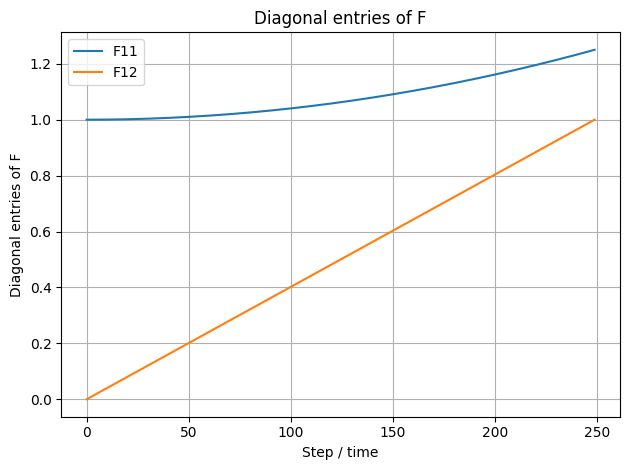

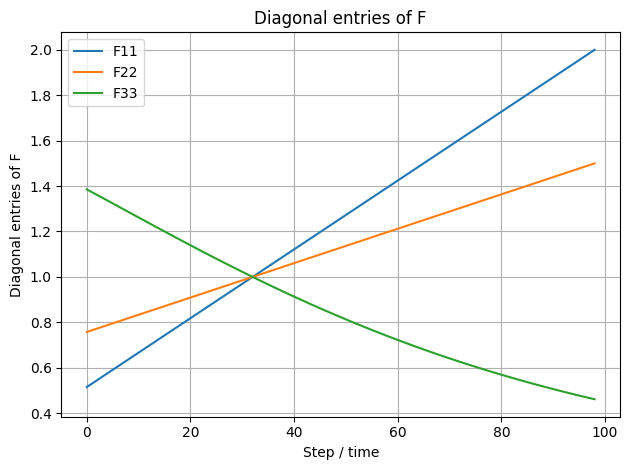

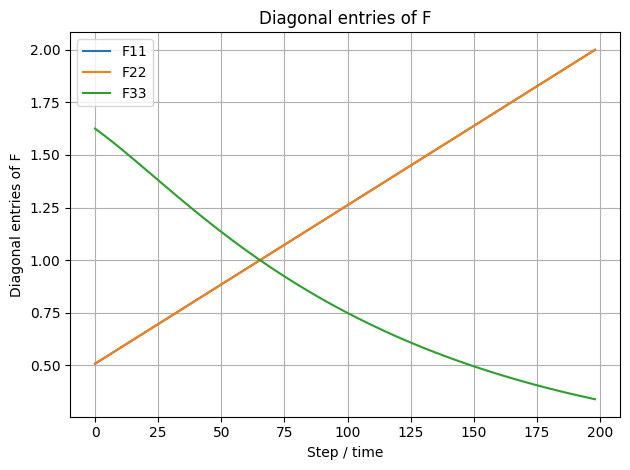

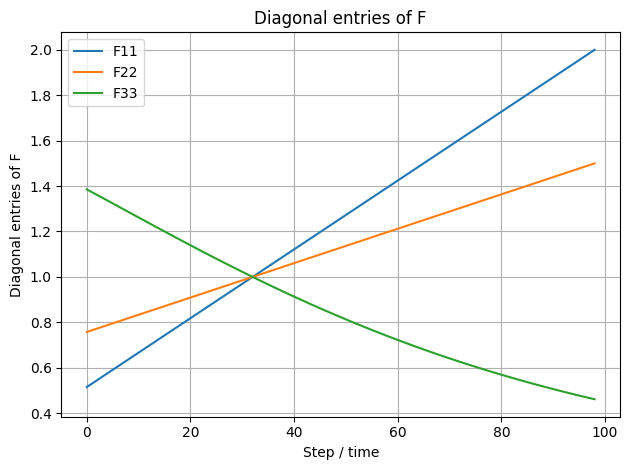

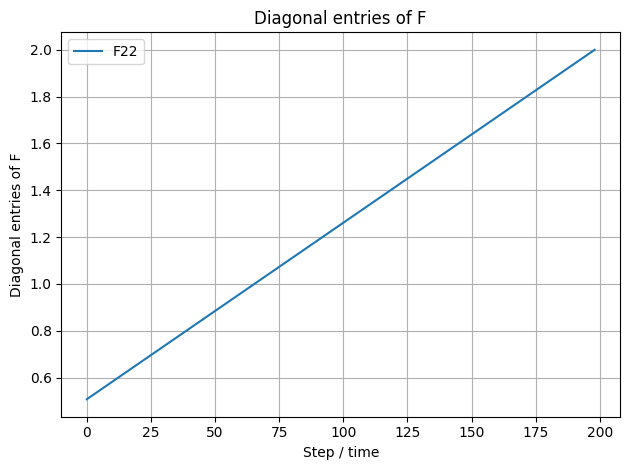

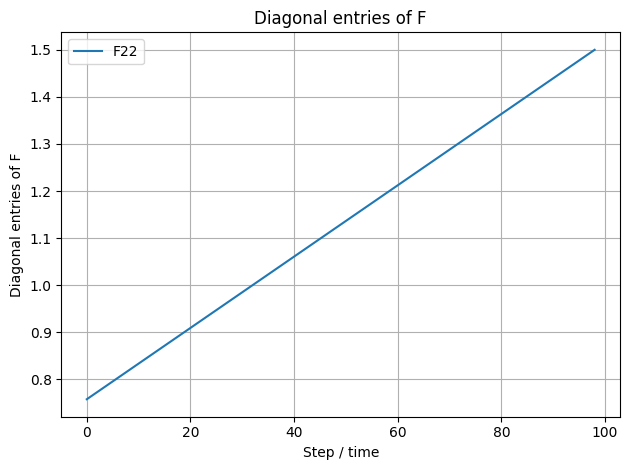

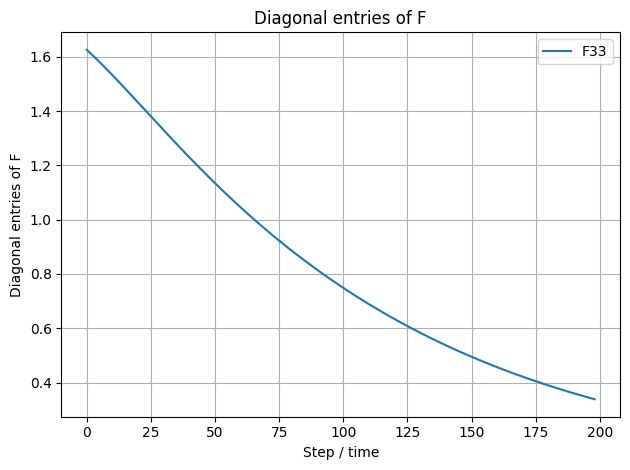

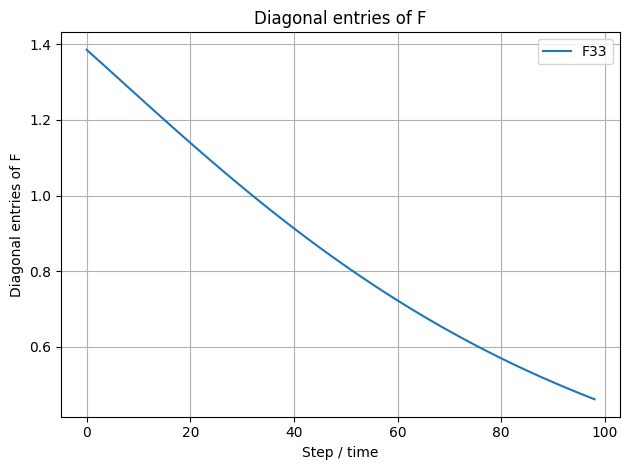

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Diagonal entries of F'}, xlabel='Step / time', ylabel='Diagonal entries of F'>)

In [7]:
vis.plot_F_diagonals(C,components=["F11","F12"])
vis.plot_F_diagonals(F_bi_test,components=["F11","F22","F33"])

vis.plot_F_diagonals(F_bi,components=["F11","F22","F33"])
vis.plot_F_diagonals(F_bi_test,components=["F11","F22","F33"])

vis.plot_F_diagonals(F_bi,components=["F22"])
vis.plot_F_diagonals(F_bi_test,components=["F22"])

vis.plot_F_diagonals(F_bi,components=["F33"])
vis.plot_F_diagonals(F_bi_test,components=["F33"])

In [8]:
F11 = F[:, 0, 0]
F22 = F[:, 1, 1]
F33 = F[:, 2, 2]
print(F11)

NameError: name 'F' is not defined

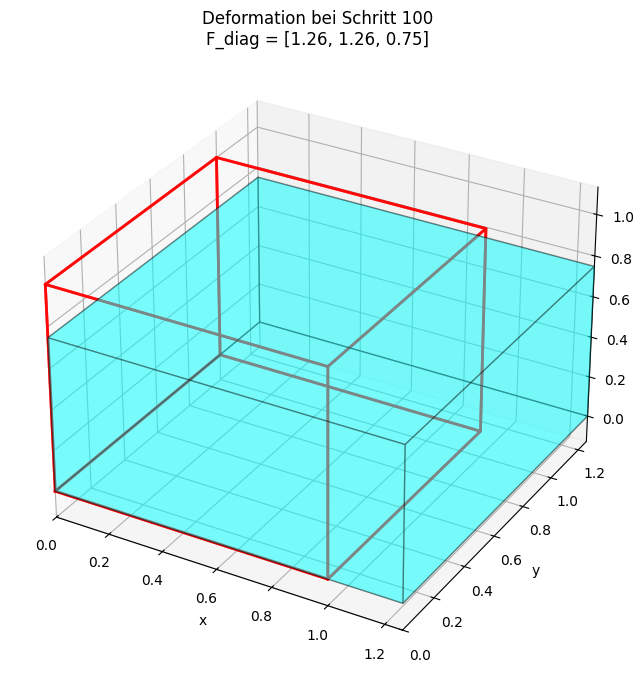

In [17]:
vis.visualize_deformation_3d(F, step_index=100)

### Task 2

In [ ]:
#Need code to create F_cal, P_cal and C_cal datasets for training from all loadcases (i think)


In [ ]:
# ------------------------------------------------------------
# Convert C (3x3) → vector of 6 independent components
# ------------------------------------------------------------
def C_to_six(C):
    return jnp.array([
        C[0,0], C[1,1], C[2,2],
        C[0,1], C[0,2], C[1,2],
    ])


# ------------------------------------------------------------
# Prepare training data for MS
# F_cal, P_cal, C_cal come from your Task 1 loading code
# ------------------------------------------------------------

X_MS = jax.vmap(C_to_six)(C_cal)   # shape (N,6)
Y_MS = P_cal.reshape(len(P_cal), 9)  # shape (N,9)


# ------------------------------------------------------------
# Build the MS model (uses your existing build() function)
# ------------------------------------------------------------
def build_MS_model(model_key, num_layers, num_nodes):
    model = tm.build(
        key=model_key,
        input_dim=6,             # 6 components of C
        output_dim=9,            # 9 components of P
        num_hidden_layers=num_layers,
        nodes_per_layer=num_nodes,
        activations=jax.nn.softplus,
        constrain_icnn_weights=False   # MS is NOT an ICNN
    )
    return model


# ------------------------------------------------------------
# Train MS model — same structure as Task 1
# ------------------------------------------------------------
def train_MS(model, train_key, steps=10000, batch_size=32, lr=1e-3):
    trained_model, history = tm.train_model(
        model=model,
        train_data=(X_MS, Y_MS),
        key=train_key,
        steps=steps,
        batch_size=batch_size,
        learning_rate=lr,
        loss_fn=tl.MSE(),
    )
    return trained_model, history
